Python script written to use materials data from MaterialUniverse and AM databases managed by Granta MI Entreprise software.<br />
Project started in October 2022.<br />
Authors: D. Mercier, J. Plocher, W. Zhao from Ansys - OoCTO.<br />

In [1]:
# Import libraries and define global variables
from GRANTA_MIScriptingToolkit import granta as mpy
import GRANTA_MIScriptingToolkit as gdl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import pandas as pd
#from wordcloud import WordCloud

In [11]:
# Connection to the virtual machine and to Granta MI session
session = gdl.GRANTA_MISession('http://azewacadmi1v1.win.ansys.com/mi_servicelayer/', autoLogon=True)
browseService = session.browseService

# Get and display all different databases availables in the Granta MI session
databases = browseService.GetDatabases().databases
#print("Found {0} databases on the Granta MI Server".format(len(databases)))
#for d in databases:
#    print("Database key: {0.DBKey}, Database name: {0.name}".format(d))
    
df = pd.DataFrame({'DBKey': [db.DBKey for db in databases],
                  'DBName': [db.name for db in databases]})
df

,DBKey,DBName
0,MI_ASM_Medical_Materials_1.54.3_2022_R1,ASM Medical Materials
1,MI_BiCrystalProject,Multiscale materials properties
2,AM_Material_Process_Data,AM_Material_Process_Data
3,MU_Sandbox_Energy_systems,Sustainability
4,MI_JAHM_1.3.3m_2021_R2,JAHM Curve Data
5,Lvl3_BuildingEnvironment,Lvl 3 - Built Environment
6,MI_Restricted_Substances,Restricted Substances
7,MI_Asphalt,MI Asphalt Database
8,HighTemperatureSuperconductors_SynthesisCharac...,HighTemperatureSuperconductors_SynthesisCharac...
9,MI_RefPapers,Academic Resources Database


In [12]:
# Get tables from a given database using dbKey
dbKey = "EduPack"
tables = browseService.GetTables(gdl.GetTables(DBKey=dbKey)).tableDetails

print("Found {0} tables in database {1}".format(len(tables), dbKey))
for t in tables:
    print("Table name: {0}".format(t.tableReference.name))

Found 27 tables in database EduPack
Table name: Coatings
Table name: Electricity mix
Table name: Elements
Table name: End of life
Table name: Legislations and Lists
Table name: Locations
Table name: Materials - in house
Table name: MaterialUniverse
Table name: Parts - Pre-defined
Table name: Power system - Energy storage
Table name: Power system - Low carbon
Table name: Power system - Nuclear
Table name: Processes - in house
Table name: ProcessUniverse
Table name: Producers
Table name: Products and parts
Table name: Reference
Table name: Resources
Table name: Restricted Substances
Table name: Shape
Table name: Specifications
Table name: Structural Sections
Table name: Suppliers
Table name: Transport
Table name: Typical materials
Table name: Use - mobile mode
Table name: Use - static mode


In [53]:
# Searching a database
table = 'MaterialUniverse'
attribute = "Material family"
tableRef = gdl.PartialTableReference(tableName=table)
attrRef = gdl.AttributeReference(name=attribute, DBKey=dbKey, partialTableReference=tableRef)

#searchValue = ["Metal (ferrous)", "Metal (non ferrous)", "Metal (precious)", "Metal (other)"]
#searchValueRef = gdl.AttributeValue(discreteDataValue=searchValue)

searchCriterion = gdl.RecordSearchCriterion(searchAttribute=attrRef, existsSearchValue=gdl.ExistsSearchValue()) #, containsSearchValue=searchValueRef
request = gdl.CriteriaSearch(DBKey=dbKey, searchCriteria=[searchCriterion])

searchResults = session.searchService.CriteriaSearch(request).searchResults

df2 = pd.DataFrame({'ShortName': [r.shortName for r in searchResults],
                     'LongName': [r.longName  for r in searchResults]})
df2

,ShortName,LongName
0,Cement (ordinary Portland),Cement (ordinary Portland)
1,Cement (Portland blast furnace),Cement (Portland blast furnace)
2,Concrete,Concrete
3,Concrete (conducting),Concrete (conducting)
4,Concrete (high alumina cement),Concrete (high alumina cement)
...,...,...
4524,"180°C max, N52UH",Neodymium magnet N52UH
4525,"FR-4.0 (Df < 0.01 at 10GHz), Epoxy/Glass fiber...","FR-4.0 (Df < 0.01 at 10GHz), Epoxy/Glass fiber..."
4526,Propylene Glycol 40,Propylene Glycol 40
4527,Ethylene Glycol 30,Ethylene Glycol 30


In [54]:
# Export data from records
attributes = ["Young's modulus", "Density", "Price", "Yield strength (elastic limit)"]

attrRefs = [gdl.AttributeReference(name=a, DBKey=dbKey, partialTableReference=tableRef) for a in attributes]
recordRefs = [r.recordReference for r in searchResults]
request = gdl.GetRecordAttributesByRefRequest(recordReferences=recordRefs, attributeReferences=attrRefs)

recordData = session.dataExportService.GetRecordAttributesByRef(request).recordData

s = [None]*len(df2)
s_high = [None]*len(df2)
s_low = [None]*len(df2)
for attribute in attributes:
    for idx, record in enumerate(recordData):
        attrValue = next((x for x in record.attributeValues if x.attributeName == attribute), None)
        s_high[idx] = attrValue.rangeDataType.high if attrValue else None
        s_low[idx] = attrValue.rangeDataType.low if attrValue else None
        s[idx] = round((s_high[idx]+s_low[idx])/2) if attrValue else None
    df2[attribute] = s
df2

,ShortName,LongName,Young's modulus,Density,Price,Yield strength (elastic limit)
0,Cement (ordinary Portland),Cement (ordinary Portland),41.0,2.0,0.0,2.0
1,Cement (Portland blast furnace),Cement (Portland blast furnace),40.0,2.0,0.0,2.0
2,Concrete,Concrete,NaN,NaN,NaN,NaN
3,Concrete (conducting),Concrete (conducting),23.0,2.0,0.0,2.0
4,Concrete (high alumina cement),Concrete (high alumina cement),27.0,2.0,0.0,3.0
...,...,...,...,...,...,...
4524,"180°C max, N52UH",Neodymium magnet N52UH,154.0,7.0,NaN,77.0
4525,"FR-4.0 (Df < 0.01 at 10GHz), Epoxy/Glass fiber...","FR-4.0 (Df < 0.01 at 10GHz), Epoxy/Glass fiber...",24.0,2.0,6.0,298.0
4526,Propylene Glycol 40,Propylene Glycol 40,NaN,1.0,NaN,NaN
4527,Ethylene Glycol 30,Ethylene Glycol 30,NaN,1.0,NaN,NaN


In [55]:
# Get Tables from Ref Papers DB
dbKey2 = "AM_Material_Process_Data"
tables = browseService.GetTables(gdl.GetTables(DBKey=dbKey2)).tableDetails

print("Found {0} tables in database {1}".format(len(tables), dbKey2))
for t in tables:
    print("Table name: {0}".format(t.tableReference.name))

Found 3 tables in database AM_Material_Process_Data
Table name: Materials
Table name: Processes
Table name: References


In [56]:
# Searching a database
table2 = 'Materials'
attribute2 = "Elastic Modulus"

tableRef = gdl.PartialTableReference(tableName=table2)
attrRef = gdl.AttributeReference(name=attribute2, DBKey=dbKey2, partialTableReference=tableRef)
searchCriterion = gdl.RecordSearchCriterion(searchAttribute=attrRef, existsSearchValue=gdl.ExistsSearchValue())
request = gdl.CriteriaSearch(DBKey=dbKey2, searchCriteria=[searchCriterion])

searchResults = session.searchService.CriteriaSearch(request).searchResults

df22 = pd.DataFrame({'ShortName': [r.shortName for r in searchResults],
                     'LongName': [r.longName  for r in searchResults]})
df22

,ShortName,LongName
0,IN718,Nickel-based superalloy
1,IN625,Nickel-based superalloy
2,Al357,Aluminium alloy
3,CoCr,Cobalt-based superalloy
4,17-4PH,Stainless Steel
5,316L,Stainless Steel
6,AlSi10Mg,Aluminium alloy
7,Ti64,Titanium alloy


In [57]:
# Export data from records
attributes2 = ["Elastic Modulus", "Yield Strength"]

attrRefs = [gdl.AttributeReference(name=a, DBKey=dbKey2, partialTableReference=tableRef) for a in attributes2]
recordRefs = [r.recordReference for r in searchResults]
request = gdl.GetRecordAttributesByRefRequest(recordReferences=recordRefs, attributeReferences=attrRefs)

recordData2 = session.dataExportService.GetRecordAttributesByRef(request).recordData

s2 = [None]*len(df22)
for attribute2 in attributes2:
    for idx, record in enumerate(recordData2):
        attrValue = next((x for x in record.attributeValues if x.attributeName == attribute2), None)
        s2[idx] = attrValue.pointDataType.points[0].value if attrValue else None
    df22[attribute2] = s2
df22

,ShortName,LongName,Elastic Modulus,Yield Strength
0,IN718,Nickel-based superalloy,161.0000,726.0
1,IN625,Nickel-based superalloy,167.0000,673.0
2,Al357,Aluminium alloy,74.8000,253.0
3,CoCr,Cobalt-based superalloy,210.0000,980.0
4,17-4PH,Stainless Steel,175.0000,821.0
5,316L,Stainless Steel,175.0000,494.0
6,AlSi10Mg,Aluminium alloy,68.1000,273.0
7,Ti64,Titanium alloy,115.2222,1180.0


<AxesSubplot:xlabel='Yield Strength', ylabel='Elastic Modulus'>

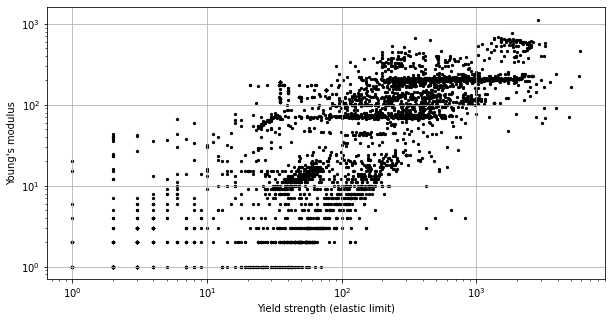

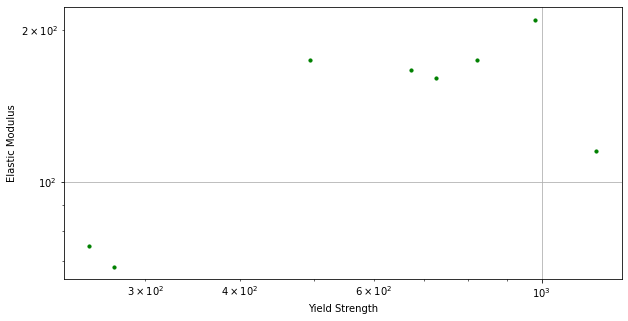

In [42]:
df2.plot.scatter(x="Yield strength (elastic limit)", y="Young's modulus", s=5, loglog=True, color='k',
grid=True, figsize=(10, 5))


df22.plot.scatter(x="Yield Strength", y="Elastic Modulus", s=10, loglog=True, color='g',
grid=True, figsize=(10, 5))

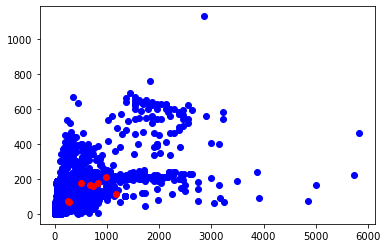

In [82]:
#xdata = pd.concat([df22["Yield Strength"], df2["Yield strength (elastic limit)"]])
#ydata = pd.concat([df22["Elastic Modulus"], df2["Young's modulus"]])

xdata1 = df22["Yield Strength"]
xdata2 = df2["Yield strength (elastic limit)"]
ydata1 = df22["Elastic Modulus"]
ydata2 = df2["Young's modulus"]

plt.scatter(xdata2, ydata2, color='b')
plt.scatter(xdata1, ydata1, color='r')
plt.show() 

#Next steps
#--> Let's filter only metals from MU to reduce the list of standard materials
#--> Add legend, axis etc
#--> Add comments, explanations...
#--> Check 
